# Model-Based Reinforcement Learning

## Motivation

### Sparse rewards
* In model-free reinforcement learning, we only obtain a reinforcement signal when encountering rewards. In environment with *sparse rewards*, the chance of obtaining a reward randomly is *negligible*, which prevents any learning.
* However, even in the *absence of rewards* we still receive a *stream of state transition data*. We could use this data to learn about the task at hand.

### Complexity of the policy/value vs dynamics:
Is it easier to decide which action is best, or to predict what is going to happen?
* Some problems can have *complex* dynamics but a *simple* optimal policy or value function. For instance, consider the problem of learning to swim. Predicting the movement requires understanding fluid dynamics and vortices while the optimal policy simply consists in moving the limbs in sync.
* Conversely, other problems can have simple dynamics but complex policies/value functions. Think of the game of Go, its rules are simplistic (placing a stone merely changes the board state at this location) but the corresponding optimal policy is very complicated.

Intuitively, model-free RL should be applied to the first category of problems and model-based RL to the second category.

### Inductive bias
Oftentimes, real-world problems exhibit a particular *structure*: for instance, any problem involving motion of physical objects will be *continuous*. It can only be *smooth*, invariant to *translations*, etc. This knowledge can then me incorporated in machine learning models to foster efficient learning. In contrast, there can often be discontinuities in the policy decisions or value function (think of a collision vs near-collision state).

###  Sample efficiency
Overall, it is generally recognized that model-based approaches tend to learn faster than model-free techniques. [ref. needed]

## Principle
We consider the optimal control problem of an MDP with a *known* reward function $R$ and subject to *unknown deterministic* dynamics $s_{t+1} = f(s_t, a_t)$:

$$\max_{(a_0,a_1,\cdots)} \sum_{t=0}^\infty \gamma^t R(s_t,a_t)$$

In model-based reinforcement learning, this problem is split into two subtasks:
1. *Model learning*:
We learn a model of the dynamics $f_\theta \simeq f$ through regression on interaction data.
2. *Planning*:
We leverage the dynamics model $f_\theta$ to compute the optimal trajectory $$\max_{(a_0,a_1,\cdots)} \sum_{t=0}^\infty \gamma^t R(\hat{s}_t,a_t)$$ following the learnt dynamics $\hat{s}_{t+1} = f_\theta(\hat{s}_t, a_t)$.

## Warming up
We start with a few useful imports.

In [1]:
# Environment
import gym
import highway_env

# Models and computation
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import namedtuple

# Visualization
import matplotlib.pyplot as plt
from tqdm import tnrange

# IO
from pathlib import Path


pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


## Experience collection
First, we randomly interact with the environment to produce a batch of experiences 

$$D = \{s_t, a_t, s_{t+1}\}_{t\in[1,N]}$$

In [2]:
Transition = namedtuple('Transition', ['state', 'action', 'next_state'])

def collect_interaction_data(env, size=10000, action_repeat=2):
    data, done = [], True
    for _ in tnrange(size, desc="Collect interaction data"):
        action = env.action_space.sample()
        for _ in range(action_repeat):
            previous_obs = env.reset() if done else obs
            obs, reward, done, info = env.step(action)
            data.append(Transition(torch.Tensor(previous_obs["observation"]),
                                   torch.Tensor(action),
                                   torch.Tensor(obs["observation"])))
    return data

env = gym.make("parking-v0")
data = collect_interaction_data(env)
print("Sample transition:", data[0])


Sample transition: Transition(state=tensor([ 0.0000,  0.0000, -0.0000, -0.0000, -0.4853, -0.8743]), action=tensor([-0.6640, -0.2663]), next_state=tensor([ 2.1467e-04,  3.8713e-04,  6.4231e-02,  1.1623e-01, -4.8367e-01,
        -8.7525e-01]))


## Build dynamics model

We choose to represent the dynamics using a structured model inspired from *LTI models* (Linear Time-Invariant):

$$\dot{x} = f_\theta(x, u) = A_\theta(x, u)x + B_\theta(x, u)u$$

Intuitively, we learn at each point $(x_t, u_t)$ the linearization of the true dynamics model $f_\theta$ with respect to $(x, u)$.

We parametrize $A_\theta$ and $B_\theta$ as two fully-connected networks with one hidden layer.


In [14]:
class DynamicsModel(nn.Module):
    STATE_X = 0
    STATE_Y = 1

    def __init__(self, state_size, action_size, hidden_size, dt):
        super().__init__()
        self.state_size, self.action_size, self.dt = state_size, action_size, dt
        A_size, B_size = state_size * state_size, state_size * action_size
        self.A1 = nn.Linear(state_size + action_size, hidden_size)
        self.A2 = nn.Linear(hidden_size, A_size)
        self.B1 = nn.Linear(state_size + action_size, hidden_size)
        self.B2 = nn.Linear(hidden_size, B_size)

    def forward(self, x, u):
        """
            Predict x_{t+1} = f(x_t, u_t)
        :param x: a batch of states
        :param u: a batch of actions
        """
        xu = torch.cat((x, u), -1)
        xu[:, self.STATE_X:self.STATE_Y+1] = 0  # Remove dependency in (x,y)
        A = self.A2(F.relu(self.A1(xu)))
        A = torch.reshape(A, (x.shape[0], self.state_size, self.state_size))
        B = self.B2(F.relu(self.B1(xu)))
        B = torch.reshape(B, (x.shape[0], self.state_size, self.action_size))
        dx = A @ x.unsqueeze(-1) + B @ u.unsqueeze(-1)
        return x + dx.squeeze()*self.dt


dynamics = DynamicsModel(state_size=env.observation_space.spaces["observation"].shape[0],
                         action_size=env.action_space.shape[0],
                         hidden_size=64,
                         dt=1/env.unwrapped.config["policy_frequency"])
print("Forward initial model on a sample transition:", dynamics(data[0].state.unsqueeze(0),
                                                                data[0].action.unsqueeze(0)).detach())

Forward initial model on a sample transition: tensor([[ 0.0410, -0.0399, -0.0534, -0.0034, -0.4319, -0.8987]])


## Fit model on data
We can now train the model to minimize an MSE loss $L^2(f_\theta; D)$ over our experience batch $D$ by sotchastic gradient descent:

$$L^2(f_\theta; D) = \frac{1}{|D|}\sum_{s_t,a_t,s_{t+1}\in D}||s_{t+1}- f_\theta(s_t, a_t))||^2$$

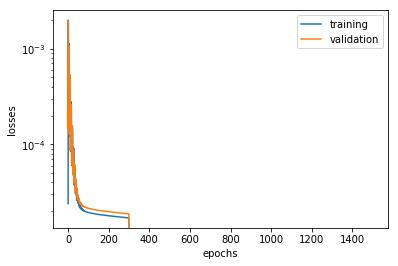

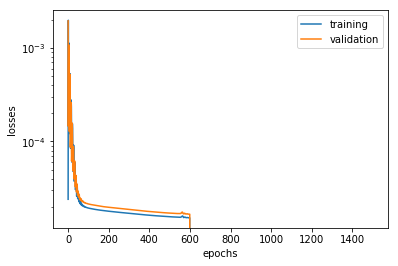

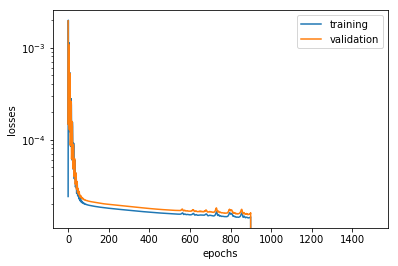

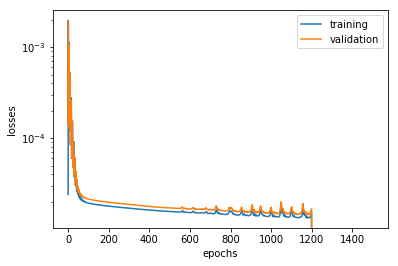

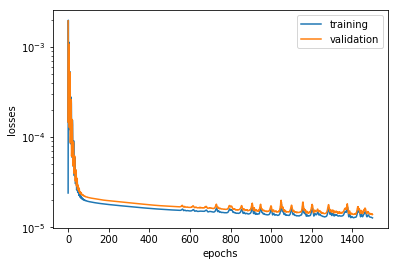

In [5]:
optimizer = torch.optim.Adam(dynamics.parameters(), lr=0.01)

# Split dataset into training and validation
train_ratio = 0.7
train_data, validation_data = data[:int(train_ratio * len(data))], \
                              data[int(train_ratio * len(data)):]

def compute_loss(model, data_t, loss_func = torch.nn.MSELoss()):
    states, actions, next_states = data_t
    predictions = model(states, actions)
    return loss_func(predictions, next_states)

def transpose_batch(batch):
    return Transition(*map(torch.stack, zip(*batch)))

def train(model, train_data, validation_data, epochs=1500):
    train_data_t = transpose_batch(train_data)
    validation_data_t = transpose_batch(validation_data)
    losses = np.zeros((epochs, 2))
    for epoch in tnrange(epochs, desc="Train dynamics model"):
        # Compute loss gradient and step optimizer
        loss = compute_loss(model, train_data_t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute and plot validation loss
        validation_loss = compute_loss(model, validation_data_t)
        losses[epoch] = [loss.detach().numpy(), validation_loss.detach().numpy()]
        if (epoch + 1) % (epochs // 5) == 0:
            plt.plot(losses)
            plt.yscale("log")
            plt.xlabel("epochs")
            plt.ylabel("losses")
            plt.legend(["training", "validation"])
            plt.show()

train(dynamics, data, validation_data)


## Visualize trained dynamics model

In order to qualitatively evaluate our model, we can choose some values of steering angle *(right, center, left)* and acceleration *(slow, fast)* and predict the corresponding trajectories from an initial state.  


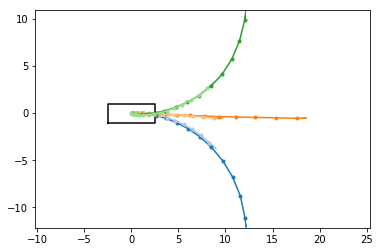

In [6]:
def predict_trajectory(state, actions, model, action_repeat=1):
    states = []
    for action in actions:
        for _ in range(action_repeat):
            state = model(state, action)
            states.append(state)
    return torch.stack(states, dim=0)

def plot_trajectory(states, color):
    scales = np.array(highway_env.envs.parking_env.ParkingEnv.DEFAULT_CONFIG["observation"]["scales"])
    states = np.clip(states.squeeze(1).detach().numpy() * scales, -100, 100)
    plt.plot(states[:, 0], states[:, 1], color=color, marker='.')
    plt.arrow(states[-1,0], states[-1,1], states[-1,4]*1, states[-1,5]*1, color=color)

def visualize_trajectories(model, state, horizon=15):
    plt.cla()
    # Draw a car
    plt.plot(state.numpy()[0]+2.5*np.array([-1, -1, 1, 1, -1]),
             state.numpy()[1]+1.0*np.array([-1, 1, 1, -1, -1]), 'k')
    # Draw trajectories
    state = state.unsqueeze(0)
    colors = iter(plt.get_cmap("tab20").colors)
    # Generate commands
    for steering in np.linspace(-0.5, 0.5, 3):
        for acceleration in np.linspace(0.8, 0.4, 2):
            actions = torch.Tensor([acceleration, steering]).view(1,1,-1)
            # Predict trajectories
            states = predict_trajectory(state, actions, model, action_repeat=horizon)
            plot_trajectory(states, color=next(colors))
    plt.axis("equal")
    plt.show()
    
visualize_trajectories(dynamics, state=torch.Tensor([0, 0, 0, 0, 1, 0]))

## Leverage dynamics model for planning

We now use the learnt dynamics model $f_\theta$ for planning.
In order to solve the optimal control problem, we use a sampling-based optimization algorithm: the *Cross-Entropy Method*.



In [12]:
def reward_model(states, goal, gamma=None):
    """
        The reward is a weighted L1-norm between the state and a goal
    :param Tensor states: a batch of states. shape: [batch_size, state_size].
    :param Tensor goal: a goal state. shape: [batch_size, state_size].
    :param float gamma: a discount factor
    """
    goal = goal.expand(states.shape)
    reward_weigths = torch.Tensor(env.unwrapped.REWARD_WEIGHTS)
    rewards = -torch.pow(torch.norm((states-goal)*reward_weigths, p=1, dim=2), 0.5)
    if gamma:
        time = torch.arange(rewards.shape[0], dtype=torch.float).unsqueeze(-1).expand(rewards.shape)
        rewards *= torch.pow(gamma, time)
    return rewards


def cem_planner(state, goal, action_size, horizon=5, population=100, selection=10, iterations=5):
    state = state.expand(population, -1)
    action_mean = torch.zeros(horizon, 1, action_size)
    action_std = torch.ones(horizon, 1, action_size)
    for _ in range(iterations):
        actions = action_mean + action_std * torch.randn(horizon, population, action_size)
        actions = torch.clamp(actions, min=env.action_space.low.min(), max=env.action_space.high.max())
        states = predict_trajectory(state, actions, dynamics, action_repeat=5)
        returns = reward_model(states, goal).sum(dim=0)
        _, best = returns.topk(selection, largest=True, sorted=False)
        best_actions = actions[:, best, :]
        action_mean, action_std = best_actions.mean(dim=1, keepdim=True), best_actions.std(dim=1, unbiased=False, keepdim=True)
    return action_mean[0].squeeze(dim=0)

# Testing
for episode in tnrange(3):
    obs, done = env.reset(), False
    while not done:
        action = cem_planner(torch.Tensor(obs["observation"]),
                             torch.Tensor(obs["desired_goal"]),
                             env.action_space.shape[0])
        obs, reward, done, info = env.step(action.numpy())
        env.render()
env.close()

## Limits

### Model bias

In model-based reinforcement learning, we replace our original optimal control problem by another problem: optimizing our learnt approximate MDP. When settling for this approximate MDP to plan with, we introduce a bias that can only decrease the true performance of the corresponding optimal policy. This is called the problem of model bias.


### Model uncertainties

The model will be accurate only on some region of the state space that was explored and covered in $D$.
Outside of $D$, the model may diverge and *hallucinate* important rewards.
This effect is problematic when the model is used by a planning algorithm, as the latter will try to exploit these hallucinated high rewards and will steer the agent towards unknown (and thus dangerous) regions.